<a href="https://colab.research.google.com/github/telafifi/MedialAxisPlayground/blob/add-python-library/medial_axis_transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
import numpy as np
from skimage.draw import polygon, line
import matplotlib.pyplot as plt
import math
from skimage.io import imread
from skimage.morphology import medial_axis, skeletonize, remove_small_objects
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_fill_holes
from scipy.spatial import KDTree

In [109]:
wall_geometry = {
    'geometry': [
        {'height': 1.0, 'p0': {'x': 3.35, 'y': 34.14}, 'p1': {'x': 3.35, 'y': 45.38}},
        {'height': 1.0, 'p0': {'x': 3.35, 'y': 45.38}, 'p1': {'x': 10.38, 'y': 45.38}},
        {'height': 1.0, 'p0': {'x': 10.38, 'y': 45.38}, 'p1': {'x': 10.38, 'y': 49.4}},
        {'height': 1.0, 'p0': {'x': 10.38, 'y': 49.4}, 'p1': {'x': 22.19, 'y': 49.4}},
        {'height': 1.0, 'p0': {'x': 22.19, 'y': 49.4}, 'p1': {'x': 22.19, 'y': 42.28}},
        {'height': 1.0, 'p0': {'x': 22.19, 'y': 42.28}, 'p1': {'x': 23.63, 'y': 42.28}},
        {'height': 1.0, 'p0': {'x': 23.63, 'y': 42.28}, 'p1': {'x': 23.63, 'y': 41.62}},
        {'height': 1.0, 'p0': {'x': 23.63, 'y': 41.62}, 'p1': {'x': 21.53, 'y': 41.62}},
        {'height': 1.0, 'p0': {'x': 21.53, 'y': 41.62}, 'p1': {'x': 21.53, 'y': 48.74}},
        {'height': 1.0, 'p0': {'x': 21.53, 'y': 48.74}, 'p1': {'x': 11.04, 'y': 48.74}},
        {'height': 1.0, 'p0': {'x': 11.04, 'y': 48.74}, 'p1': {'x': 11.04, 'y': 44.72}},
        {'height': 1.0, 'p0': {'x': 11.04, 'y': 44.72}, 'p1': {'x': 4.01, 'y': 44.72}},
        {'height': 1.0, 'p0': {'x': 4.01, 'y': 44.72}, 'p1': {'x': 4.01, 'y': 34.14}},
        {'height': 1.0, 'p0': {'x': 4.01, 'y': 34.14}, 'p1': {'x': 4.01, 'y': 23.38}},
        {'height': 1.0, 'p0': {'x': 4.01, 'y': 23.38}, 'p1': {'x': 4.01, 'y': 22.64}},
        {'height': 1.0, 'p0': {'x': 4.01, 'y': 22.64}, 'p1': {'x': 3.35, 'y': 22.64}},
        {'height': 1.0, 'p0': {'x': 3.35, 'y': 22.64}, 'p1': {'x': 3.35, 'y': 24.04}},
        {'height': 1.0, 'p0': {'x': 3.35, 'y': 24.04}, 'p1': {'x': 3.35, 'y': 34.14}},
    ],
    'id': '0e62311a-9dea-40ad-ab8a-13a427e73d0f',
    'is_exterior': True,
}


In [110]:
# Define padding
padding = 10  # You can adjust this value
scale = 12 # you can adjust this value

# Calculate the bounding box
min_x = min(min(wall['p0']['x'] * scale, wall['p1']['x'] * scale) for wall in wall_geometry['geometry'])
max_x = max(max(wall['p0']['x'] * scale, wall['p1']['x'] * scale) for wall in wall_geometry['geometry'])
min_y = min(min(wall['p0']['y'] * scale, wall['p1']['y'] * scale) for wall in wall_geometry['geometry'])
max_y = max(max(wall['p0']['y'] * scale, wall['p1']['y'] * scale) for wall in wall_geometry['geometry'])

# Add padding
min_x = max(min_x - padding, 0)
min_y = max(min_y - padding, 0)
max_x += padding
max_y += padding

In [111]:
# Determine the size of the image
image_width = math.ceil(max_x)
image_height = math.ceil(max_y)

# Create the binary image
image = np.zeros((image_height, image_width), dtype=bool)

# Draw the polygon based on the wall geometry
for wall in wall_geometry['geometry']:
    rr, cc = line(int(wall['p0']['y'] * scale), int(wall['p0']['x'] * scale), int(wall['p1']['y'] * scale), int(wall['p1']['x'] * scale))
    image[rr, cc] = True

In [112]:
# Optionally, fill the polygon if the lines do not create a filled shape
image = binary_fill_holes(image)

# Compute the medial axis
medial_axis_image, distances = medial_axis(image, return_distance=True)

# Skeletonize the medial axis to ensure it is 1 pixel wide
skeleton = skeletonize(medial_axis_image)

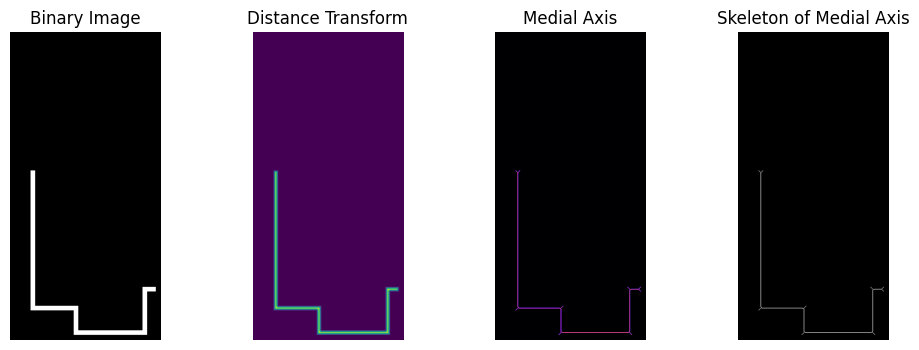

In [113]:
# Plotting the result
fig, ax = plt.subplots(1, 4, figsize=(12, 4))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Binary Image')
ax[0].axis('off')

ax[1].imshow(distances, cmap='viridis')
ax[1].set_title('Distance Transform')
ax[1].axis('off')

ax[2].imshow(medial_axis_image, cmap='magma')
ax[2].set_title('Medial Axis')
ax[2].axis('off')

ax[3].imshow(skeleton, cmap=plt.cm.gray)
ax[3].set_title('Skeleton of Medial Axis')
ax[3].axis('off')

plt.show()

In [114]:
def find_skeleton_points(skeleton):
    # Find all non-zero points in the skeleton
    points = np.column_stack(np.where(skeleton))

    # Placeholder function to create segments from a path (simplified for demonstration)
    # In practice, you would need a more complex algorithm to handle multiple branching paths
    segments = []
    newPoints = []
    for i in range(0, len(points)):
        point = tuple(points[i])
        newPoints.append({ 'x': point[1], 'y': point[0] })
    return newPoints

print(find_skeleton_points(skeleton))

[{'x': 40, 'y': 271}, {'x': 48, 'y': 271}, {'x': 41, 'y': 272}, {'x': 47, 'y': 272}, {'x': 42, 'y': 273}, {'x': 46, 'y': 273}, {'x': 43, 'y': 274}, {'x': 45, 'y': 274}, {'x': 44, 'y': 275}, {'x': 44, 'y': 276}, {'x': 44, 'y': 277}, {'x': 44, 'y': 278}, {'x': 44, 'y': 279}, {'x': 44, 'y': 280}, {'x': 44, 'y': 281}, {'x': 44, 'y': 282}, {'x': 44, 'y': 283}, {'x': 44, 'y': 284}, {'x': 44, 'y': 285}, {'x': 44, 'y': 286}, {'x': 44, 'y': 287}, {'x': 44, 'y': 288}, {'x': 44, 'y': 289}, {'x': 44, 'y': 290}, {'x': 44, 'y': 291}, {'x': 44, 'y': 292}, {'x': 44, 'y': 293}, {'x': 44, 'y': 294}, {'x': 44, 'y': 295}, {'x': 44, 'y': 296}, {'x': 44, 'y': 297}, {'x': 44, 'y': 298}, {'x': 44, 'y': 299}, {'x': 44, 'y': 300}, {'x': 44, 'y': 301}, {'x': 44, 'y': 302}, {'x': 44, 'y': 303}, {'x': 44, 'y': 304}, {'x': 44, 'y': 305}, {'x': 44, 'y': 306}, {'x': 44, 'y': 307}, {'x': 44, 'y': 308}, {'x': 44, 'y': 309}, {'x': 44, 'y': 310}, {'x': 44, 'y': 311}, {'x': 44, 'y': 312}, {'x': 44, 'y': 313}, {'x': 44, 'y

In [115]:

points = np.column_stack(np.where(skeleton))
def distance(p1, p2):
    """Calculate the Euclidean distance between two points."""
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def nearest_neighbor_kd_tree(points):
    """Order points by connecting to the nearest unvisited point using a k-d tree for efficient nearest neighbor search."""
    tree = KDTree(points)  # Build the k-d tree from the points
    current_index = 0
    path_indices = [current_index]
    visited = set(path_indices)

    while len(visited) < len(points):
        # Query the k-d tree for the nearest neighbor to the current point
        # distance, index = tree.query(points[current_index], k=2)  # k=2 because the nearest (first) will be the point itself
        # To ensure we get the next closest unvisited, loop to find the closest valid point
        distances, indices = tree.query(points[current_index], k=len(points))
        for index in indices:
            if index not in visited:
                visited.add(index)
                path_indices.append(index)
                current_index = index
                break

    # Convert indices back to points
    ordered_points = [points[index] for index in path_indices]
    return ordered_points

def format_segments_as_json(points, max_distance):
    """Create a list of segments from a list of ordered points in the desired JSON-like format."""
    segments = []
    for i in range(1, len(points)):
        if distance(points[i-1], points[i]) <= max_distance:
            segment = {
                'type': 'segment',
                'p1': {'x': points[i-1][1], 'y': points[i-1][0]},
                'p2': {'x': points[i][1], 'y': points[i][0]}
            }
            segments.append(segment)
    return segments

ordered_points = nearest_neighbor_kd_tree(points)
print(format_segments_as_json(ordered_points, 2))

[{'type': 'segment', 'p1': {'x': 40, 'y': 271}, 'p2': {'x': 41, 'y': 272}}, {'type': 'segment', 'p1': {'x': 41, 'y': 272}, 'p2': {'x': 42, 'y': 273}}, {'type': 'segment', 'p1': {'x': 42, 'y': 273}, 'p2': {'x': 43, 'y': 274}}, {'type': 'segment', 'p1': {'x': 43, 'y': 274}, 'p2': {'x': 44, 'y': 275}}, {'type': 'segment', 'p1': {'x': 44, 'y': 275}, 'p2': {'x': 44, 'y': 276}}, {'type': 'segment', 'p1': {'x': 44, 'y': 276}, 'p2': {'x': 44, 'y': 277}}, {'type': 'segment', 'p1': {'x': 44, 'y': 277}, 'p2': {'x': 44, 'y': 278}}, {'type': 'segment', 'p1': {'x': 44, 'y': 278}, 'p2': {'x': 44, 'y': 279}}, {'type': 'segment', 'p1': {'x': 44, 'y': 279}, 'p2': {'x': 44, 'y': 280}}, {'type': 'segment', 'p1': {'x': 44, 'y': 280}, 'p2': {'x': 44, 'y': 281}}, {'type': 'segment', 'p1': {'x': 44, 'y': 281}, 'p2': {'x': 44, 'y': 282}}, {'type': 'segment', 'p1': {'x': 44, 'y': 282}, 'p2': {'x': 44, 'y': 283}}, {'type': 'segment', 'p1': {'x': 44, 'y': 283}, 'p2': {'x': 44, 'y': 284}}, {'type': 'segment', 'p1'